In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-07-18 06:16:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.07s   

2020-07-18 06:16:09 (68.4 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [7]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_portion = .8

In [8]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))


153


In [14]:
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
      labels.append(row[0])
      sentence = row[1]
      for word in stopwords:
        token = " " + word + " "
        sentence = sentence.replace(token, " ")
      sentences.append(sentence)

    
print(len(labels))
print(len(sentences))
print(sentences[0])


4450
4450
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertai

In [15]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))


3560
3560
3560
890
890


In [16]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen = max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))


449
120
200
120
192
120


In [17]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)


890
(890, 120)


In [18]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)


[4]
[2]
[1]
(3560, 1)
[4]
[5]
[4]
(890, 1)


In [19]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length= max_length),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs= num_epochs, validation_data=(validation_padded, validation_label_seq))

Epoch 1/30
112/112 [==============================] - 1s 7ms/step - loss: 1.7149 - accuracy: 0.3298 - val_loss: 1.6071 - val_accuracy: 0.3865
Epoch 2/30
112/112 [==============================] - 1s 5ms/step - loss: 1.4354 - accuracy: 0.5298 - val_loss: 1.2549 - val_accuracy: 0.6236
Epoch 3/30
112/112 [==============================] - 1s 5ms/step - loss: 1.0458 - accuracy: 0.7051 - val_loss: 0.9007 - val_accuracy: 0.7708
Epoch 4/30
112/112 [==============================] - 1s 6ms/step - loss: 0.7340 - accuracy: 0.8208 - val_loss: 0.6469 - val_accuracy: 0.8685
Epoch 5/30
112/112 [==============================] - 1s 5ms/step - loss: 0.5116 - accuracy: 0.9208 - val_loss: 0.4695 - val_accuracy: 0.9034
Epoch 6/30
112/112 [==============================] - 1s 6ms/step - loss: 0.3598 - accuracy: 0.9402 - val_loss: 0.3514 - val_accuracy: 0.9270
Epoch 7/30
112/112 [==============================] - 1s 5ms/step - loss: 0.2614 - accuracy: 0.9553 - val_loss: 0.2794 - val_accuracy: 0.9371
Epoch 

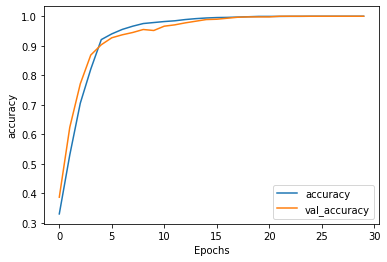

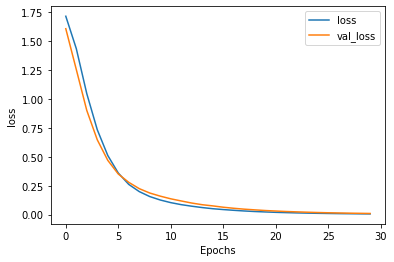

In [22]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [23]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [29]:

reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
def decode_sentence(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [28]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(1000, 16)
